In [1]:
from data_utils import load_data, notnan_indices, downsample_signal, moving_average

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import csaps

In [2]:
data_dir = "./data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(os.path.join(data_dir, virgo_file))

t = data["timestamp"]  # Time in mission days
# t = data["timestamp"].apply(mission_day_to_year)  # Uncomment for time measured in years
pmo_a = data["pmo6v_a"]
pmo_b = data["pmo6v_b"]
temp = data["temperature"]
data.sample(15, random_state=2)

,timestamp,pmo6v_a,pmo6v_b,temperature
916133,707.2037,1364.124,NaN,27.612
4540366,3224.0322,1360.755,NaN,29.833
1184820,893.7919,1363.791,NaN,26.496
1652927,1218.8662,1363.623,NaN,26.422
6541184,4613.4893,NaN,NaN,29.463
6169960,4355.6948,1360.001,NaN,31.748
9447604,6631.8364,1359.868,NaN,29.349
10494042,7358.5293,1359.368,NaN,29.713
11214199,7858.6382,1358.931,NaN,27.109
7101944,5002.9058,1359.604,NaN,28.829


In [3]:
data_nn = data[["timestamp", "pmo6v_a", "pmo6v_b"]].dropna()
t_nn = data_nn["timestamp"]
x_a_nn = data_nn["pmo6v_a"]
x_b_nn = data_nn["pmo6v_b"]
ratio_a_b = x_a_nn/x_b_nn

plt.figure(5, figsize=(16, 8))
#plt.plot(t_nn, ratio_a_b, t_nn, np.exp(a*t_nn+b))
plt.plot(t_nn, np.log(ratio_a_b-0.995), t_nn, a*t_nn+b)
plt.savefig(os.path.join(results_dir, "ratio_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

NameError: name 'a' is not defined

<Figure size 1152x576 with 0 Axes>

In [ ]:
def exponential_decay(t, a, b):
    return a + np.exp(b*(t))

In [ ]:
X= np.array(t_nn).reshape(-1,1)
logY = np.log(np.array(ratio_a_b)-0.995)

In [ ]:
plt.plot(X, logY)

In [7]:
reg = LinearRegression().fit(X, logY)

In [8]:
reg.coef_

array([-0.00037167])

In [9]:
reg.intercept_

-5.31379277331559

In [10]:
a = reg.coef_[0]
b = reg.intercept_

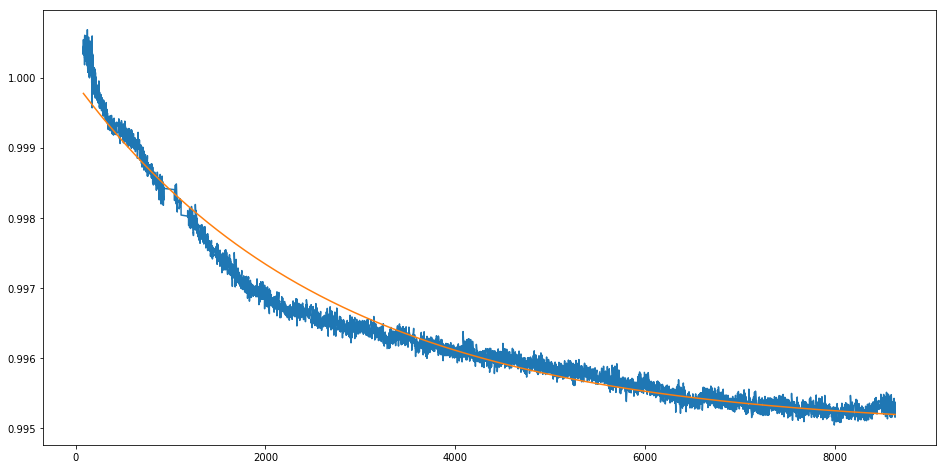

In [11]:
plt.figure(5, figsize=(16, 8))
plt.plot(t_nn, ratio_a_b, t_nn, np.exp(a*t_nn + b)+0.995)


In [12]:
from sklearn.svm import SVR

In [193]:
data = np.stack((t_nn, ratio_a_b)).T
data = data[::10]
data.shape

(2153, 2)

In [194]:
y= data[:,1]
X = data[:,0].T.reshape(-1,1)

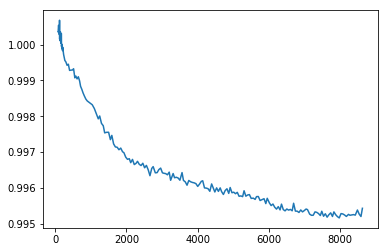

In [22]:
plt.plot(X, y)

In [155]:
cost_param = [10**i for i in range(-4,5)]
epsilon_param = [10**i for i in range(-4, 5)]
degree_param = [i for i in range(2, 6)]

param_grid = [
    {
        'C' : cost_param,
        'epsilon' : epsilon_param,
        'degree' : degree_param
    },
]

In [156]:
grid = GridSearchCV(SVR(kernel='poly', 
                        gamma='scale'),
                    cv=10, 
                    n_jobs=-1, 
                    param_grid=param_grid)

In [ ]:
start_time = time.time()
grid.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

In [144]:
clf = SVR(C=1e-3, gamma='auto', epsilon=1e-20, kernel='rbf')
clf.fit(X, y)

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=1e-20, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

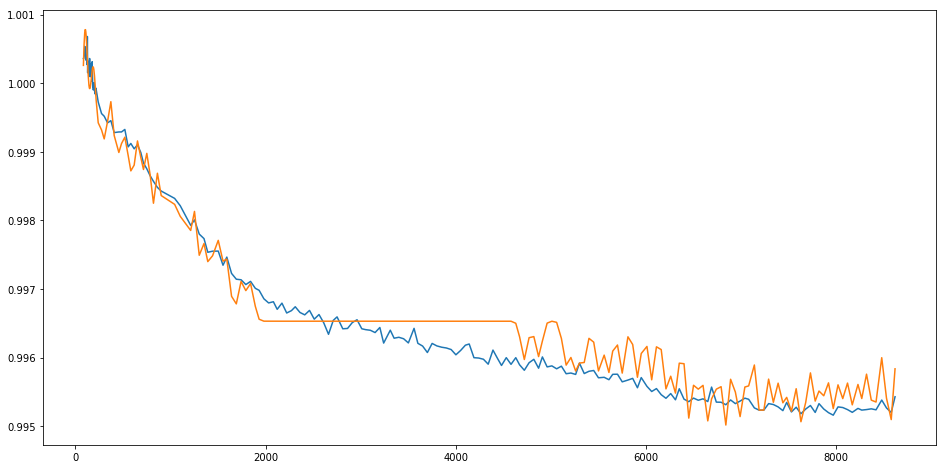

In [154]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, X, grid.predict(X.reshape(-1,1)))

In [110]:
sp = csaps.UnivariateCubicSmoothingSpline(X.ravel(), y, smooth=1e-10) 

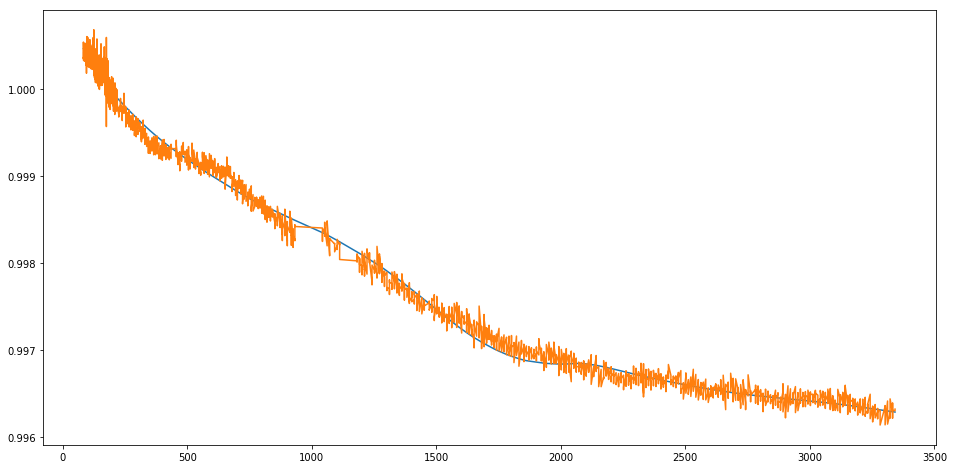

In [111]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), sp(X.ravel()), X.ravel(), y)

In [68]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared

In [95]:
kernel = 10*(WhiteKernel() * RBF() + RationalQuadratic() + ExpSineSquared())

In [96]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.73690285e-03,  1.39750843e+02, -0.00000000e+00,  2.70022359e-03,
       -6.32436173e-03, -1.76264235e-02,  1.39167453e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 117, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)


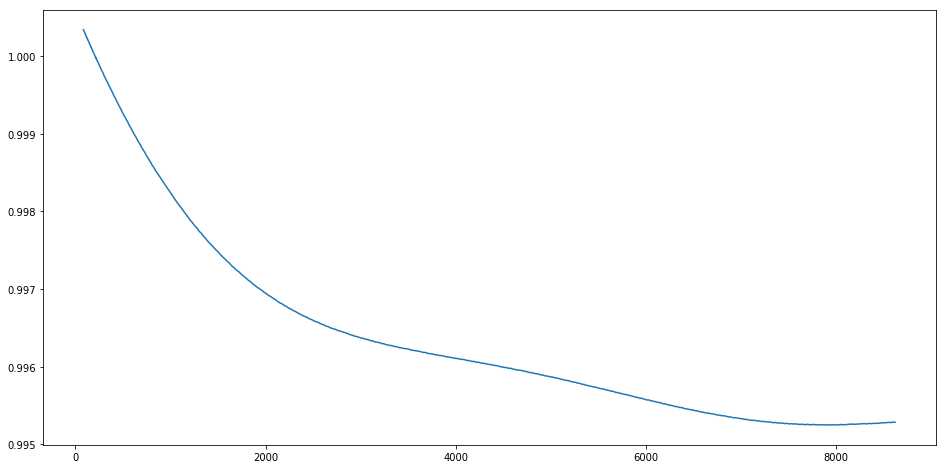

In [97]:
plt.figure(5, figsize=(16, 8))
plt.plot(X, gpr.predict(X))

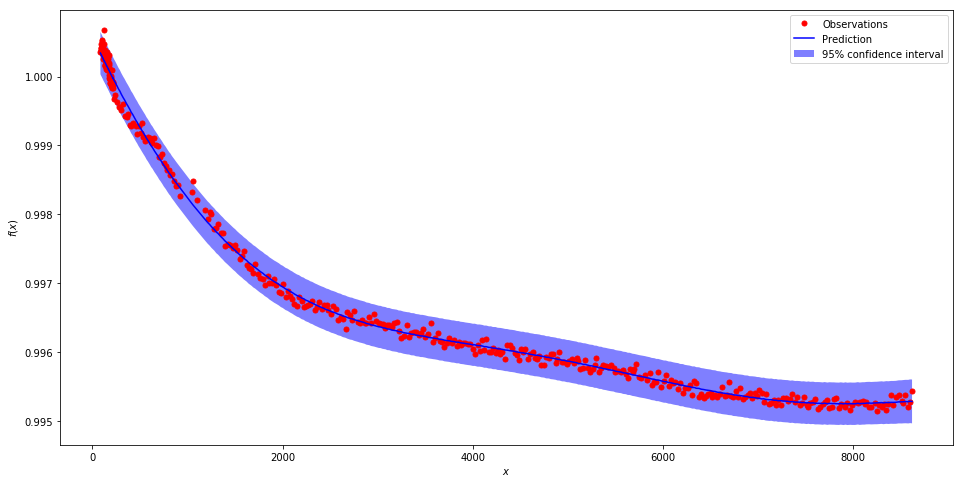

In [102]:
y_pred, sigma = gpr.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.ylim(0.995, 1)
#plt.xlim(2000, 4000)
plt.legend(loc='upper right')

In [144]:
from scipy.interpolate import UnivariateSpline

In [146]:
spline_1 = UnivariateSpline(X, y, k=3, s=0.2*1e-5)

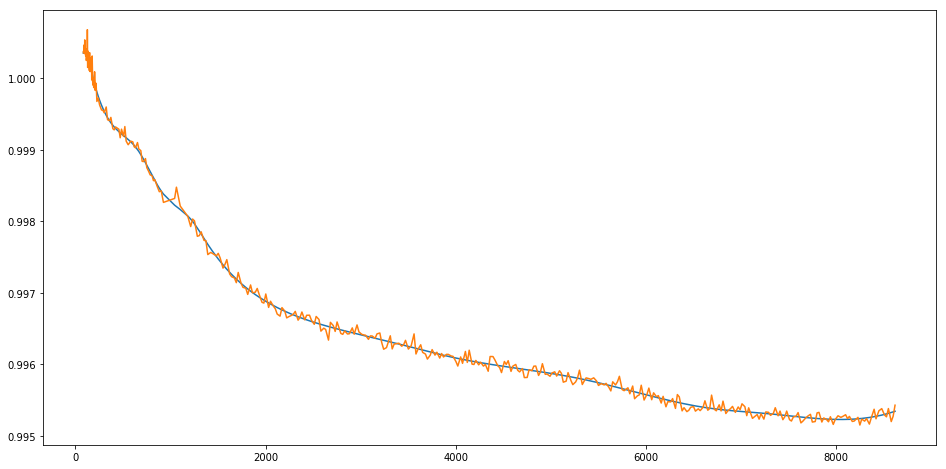

In [147]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), spline_1(X.ravel()), X.ravel(), y)

In [216]:
from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import minimize

def guess(x, y, k, s, w=None):
    """Do an ordinary spline fit to provide knots"""
    return splrep(x, y, w, k=k, s=s)

def err(c, x, y, t, k, w=None):
    """The error function to minimize"""
    diff = y - splev(x, (t, c, k))
    if w is None:
        diff = np.einsum('...i,...i', diff, diff)
    else:
        diff = np.dot(diff*diff, w)
    return np.abs(diff)

def spline_dirichlet(x, y, k=3, s=0, w=None):
    t, c0, k = guess(x, y, k, s, w=w)
    x0 = x[0] # point at which 1 is required
    con = {'type': 'eq',
           'fun': lambda c: splev(x0, (t, c, k), der=0)-1,
           }
    opt = minimize(err, c0, (x, y, t, k, w), constraints=con)
    copt = opt.x
    return UnivariateSpline._from_tck((t, copt, k))

In [217]:
sp = spline_dirichlet(X.ravel(), y, k=3, s=0.2*1e-4)

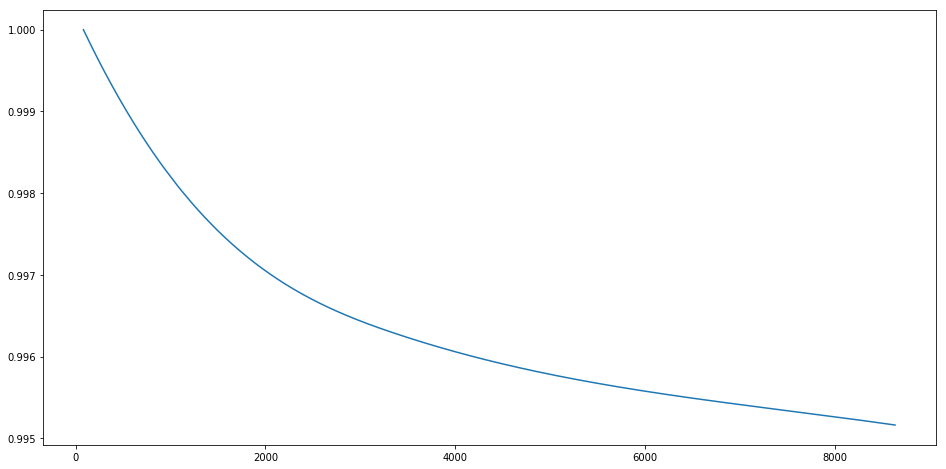

In [218]:
plt.figure(5, figsize=(16, 8))
plt.plot(X.ravel(), sp(X.ravel()),)